# Model vectorization

> **tldr:** This notebook explains how to use `VectorizedModel` for efficient, vectorized simulations (e.g., over batches or ensembles). You will learn how to create a vectorized model using `VectorizedModel.from_model_with_vectorization` (or the `to_vectorized` helper method). This is done by providing "vector specs"—a dictionary that maps slices of the model state (like `Prognostic` or `DynamicInput`) to coordinates to vectorize over. The notebook demonstrates through batch and ensemble examples how the order of operations is critical: updating state (like dynamic inputs) before vectorizing shares that state across all instances, while updating after vectorization allows each instance to use different data.

Efficient training and evaluation require running simulations vectorized over axes (like batches or ensembles). NeuralGCM provides the `VectorizedModel` to simplify this process.

Outline:
1. How to vectorize `Model` instance
2. Examples zoo: batched rollout, ensemble rollout

In [3]:
# Imports { form-width: "30%" }

import functools

import coordax as cx
from flax import nnx
import jax
import jax.numpy as jnp
import jax_datetime as jdt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray

from neuralgcm.experimental.core import api
from neuralgcm.experimental.core import coordinates
from neuralgcm.experimental.core import diagnostics
from neuralgcm.experimental.core import dynamic_io
from neuralgcm.experimental.core import random_processes
from neuralgcm.experimental.core import module_utils
from neuralgcm.experimental.core import observation_operators
from neuralgcm.experimental.core import nnx_compat
from neuralgcm.experimental.core import typing
from neuralgcm.experimental.core import xarray_utils

In [ ]:
#@title Implementation and helper methods for demo GameOfLife `Model`

def calculate_sub_steps(
    timestep: np.timedelta64, duration: typing.TimedeltaLike
) -> int:
  """Calculate the number of time-steps required to simulate a time interval."""
  duration = pd.Timedelta(duration)
  time_step_ratio = duration / timestep
  if abs(time_step_ratio - round(time_step_ratio)) > 1e-6:
    raise ValueError(
        f'non-integral time-step ratio: {duration=} is not a multiple of '
        f'the internal model timestep {timestep}'
    )
  return round(time_step_ratio)



def unroll_model(
    model,
    outer_steps: int,
    timedelta: typing.TimedeltaLike | None,
    observe_fn,
) -> tuple[typing.ModelState, typing.Pytree]:
  model_state_axes_spec = nnx.StateAxes({typing.SimulationVariable: nnx.Carry, ...: None})
  if timedelta is None:
    timedelta = model.timestep
  inner_steps = calculate_sub_steps(model.timestep, timedelta)

  def _inner_step(model):
    model.advance()

  inner_step_fn = nnx.scan(
      _inner_step,
      length=inner_steps,
      in_axes=model_state_axes_spec,
      out_axes=0,
  )

  def _step(model):
    observation = observe_fn(model)
    inner_step_fn(model)
    return observation

  unroll_fn = nnx.scan(
      _step,
      length=outer_steps,
      in_axes=model_state_axes_spec,
      out_axes=0,
  )
  observations = unroll_fn(model)
  time = coordinates.TimeDelta(np.arange(outer_steps) * timedelta)
  observations = cx.tag(observations, time)
  return observations

def game_of_life_step(
    state: jax.Array,
    danger_roll: jax.Array | float = 0.0,
    danger_threshold: jax.Array | float = 1.0,
) -> jax.Array:
  """Advances 2d periodic array representing the state of game of life."""
  alive_neighbors = sum(
      jnp.roll(jnp.roll(state, i, axis=0), j, axis=1)
      for i in (-1, 0, 1) for j in (-1, 0, 1) if (i != 0 and j != 0)
  )
  no_accident = jnp.broadcast_to(danger_roll < danger_threshold, state.shape)
  return ((alive_neighbors == 3) | (state & (alive_neighbors == 2))) & no_accident


def random_life_state(
    rng: jax.Array,
    world_shape: tuple[int, int],
) -> jax.Array:
  """Generates a random state for the game of life."""
  return jax.random.bernoulli(rng, shape=world_shape)


@nnx_compat.dataclass
class GameOfLife(api.Model):
  """Demo model simulating stochastic game of life with forcing."""

  x: cx.Coordinate
  y: cx.Coordinate
  threshold_to_live: dynamic_io.DynamicInputSlice | None = None
  random_roll: random_processes.NormalUncorrelated | None = None
  world_key: str = 'game'
  state_key: str = 'u'

  @property
  def xy(self):
    return cx.compose_coordinates(self.x, self.y)

  def __post_init__(self):
    self.prognostics = typing.Prognostic({
        self.state_key: cx.field(np.zeros(self.xy.shape, dtype=bool), self.xy),
        'time': cx.field(jdt.Datetime.from_isoformat('2000-01-01')),
    })

  def game_step(self, u, roll, threshold):
    game_step_fn = cx.cmap(game_of_life_step, out_axes=u.named_axes)
    return game_step_fn(u, roll, threshold).tag(self.xy)

  @module_utils.ensure_unchanged_state_structure
  def assimilate(self, observations):
    data = observations[self.world_key]
    self.prognostics.value = dict(sorted({
        self.state_key: data[self.state_key],
        'time': data['time'],
    }.items()))

  @module_utils.ensure_unchanged_state_structure
  def advance(self):
    time = self.prognostics.value['time']
    if self.threshold_to_live is not None:
      threshold = self.threshold_to_live(time)['zzz'].untag(self.xy)
    else:
      threshold = 1.0
    if self.random_roll is not None:
      roll_values = self.random_roll.state_values(coords=self.xy).untag(self.xy)
      self.random_roll.advance()
    else:
      roll_values = 0.0

    u = self.prognostics.value[self.state_key].untag(self.xy)
    next_u = self.game_step(u, roll_values, threshold)
    time = time + self.timestep
    self.prognostics.value = dict(sorted({
        self.state_key: next_u,
        'time': time,
    }.items()))

  @module_utils.ensure_unchanged_state_structure
  def observe(self, query):
    prognostic = self.prognostics.value
    diagnostic = self.diagnostic_values()
    operators = {
        self.world_key: observation_operators.DataObservationOperator(prognostic),
        'diagnostic': observation_operators.DataObservationOperator(diagnostic),
    }
    result = {}
    for k, q in query.items():
      result[k] = operators[k].observe(prognostic, q)
    return result

  @property
  def timestep(self):
    return np.timedelta64(1, 's')

## Creating vectorized model

**Key concepts:**
* `VectorizedModel.from_model_with_vectorization` classmethod is used to instantiate a vectorized model
* `VectorizedModel` wraps a model instance, vectorizing its state and storing metadata about the vectorization axes.
* Vectorization metadata is stored as `dict[nnx.filterlib.Filter, cx.Coordinate]` mapping slice of model state to vectorization coordinate

To create a comprehensive example, this demo uses a simple GameOfLife model but includes ad-hoc components for diagnostics, randomness, and dynamic inputs.

First we create a `Model` instance

In [ ]:
# defining coordinate used by the model;
x = cx.LabeledAxis('x', np.linspace(0, 1))
y = cx.LabeledAxis('y', np.linspace(0, 1))
xy = cx.compose_coordinates(x, y)

def build_new_model():
  # Defining diagnostic module;
  count_alive = cx.cmap(lambda x: jnp.sum(x).astype(float))
  extract_n_alive = lambda x, *a, **kw: {'n_alive': count_alive(x.untag(xy))}
  diagnostic_coords = {'n_alive': cx.Scalar()}
  n_alive_diagnostic = diagnostics.InstantDiagnostic(extract_n_alive, diagnostic_coords)

  # Instantiating the model.
  threshold_to_live = dynamic_io.DynamicInputSlice({'zzz': xy}, 'life')
  random_roll = random_processes.NormalUncorrelated(xy, 0, 1, nnx.Rngs(0))
  life = GameOfLife(x, y, threshold_to_live, random_roll)

  # Attaching diagnostic module;
  life = module_utils.with_callback(life, n_alive_diagnostic, 'game_step')
  return life


life = build_new_model()

INFO:2025-10-16 11:16:06,087:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': UNKNOWN: TPU initialization failed: No jellyfish device found.
INFO:2025-10-16 11:16:06,089:jax._src.xla_bridge:822: Unable to initialize backend 'pathways': Could not initialize backend 'pathways'
INFO:2025-10-16 11:16:06,090:jax._src.xla_bridge:822: Unable to initialize backend 'proxy': INVALID_ARGUMENT: IFRT proxy server address must be '<transport-type>://<backend-address>' (e.g., 'grpc://localhost'), but got 
INFO:2025-10-16 11:16:06,091:jax._src.xla_bridge:822: Unable to initialize backend 'mock_tpu': Must pass --mock_tpu_platform flag to initialize the mock_tpu backend


Let's look at what prognostics of this model look like:
(to do this we will extract a SimulationState and peek at prognostics slice)

In [ ]:
print(life.simulation_state.prognostics)

State({
  'wrapped_instance': {
    'prognostics': Prognostic( # 2,502 (2.5 KB)
      value={'u': <Field (
        dims=('x', 'y'),
        shape=(50, 50),
        axes={
          'x': LabeledAxis(name='x', ticks=<np float64(50,)>),
          'y': LabeledAxis(name='y', ticks=<np float64(50,)>),
        },
      ), 'time': <Field dims=() shape=() axes={} >}
    )
  }
})


We see that the standard model includes prognostic `u` with dimensions "x, y".

Now that we have a model instance, we can create a vectorized version of it. This is done by providing a "vector spec"—a dictionary mapping the state slices you want to vectorize (e.g., `Prognostic`) to their new coordinate (e.g., batch).

As a first example let's vectorize full simulation state over a `batch` axis

In [ ]:
batch = cx.SizedAxis('batch', 4)
vector_specs = {typing.SimulationVariable: batch}
v_life = api.VectorizedModel.from_model_with_vectorization(life, vector_specs)

Looking at prognostics of this model we note that the state has been replicated:

In [ ]:
print(v_life.simulation_state.prognostics)

State({
  'wrapped_instance': {
    'prognostics': Prognostic( # 10,008 (10.0 KB)
      value={'time': <Field dims=('batch',) shape=(4,) axes={'batch': SizedAxis} >, 'u': <Field (
        dims=('batch', 'x', 'y'),
        shape=(4, 50, 50),
        axes={
          'batch': SizedAxis(name='batch', size=4),
          'x': LabeledAxis(name='x', ticks=<np float64(50,)>),
          'y': LabeledAxis(name='y', ticks=<np float64(50,)>),
        },
      )}
    )
  }
})


Vectorization metadata is stored on a `vector_axes` property.

In [ ]:
print(v_life.vector_axes)

{<class 'neuralgcm.experimental.core.typing.SimulationVariable'>: coordax.SizedAxis('batch', size=4), Ellipsis: Scalar()}


Vectorization metadata is used for several purposes:
1. It assists with automatic vectorization telling `nnx.vmap` how to map over different model slices
2. It is used to robustly "untag" and "tag" coordinates of the model state before and after vectorized calls

If we were to vectorize model again, the metadata would be combined. For example, adding an ensemble vectorization on top of batch will result in:

In [ ]:
ensemble = cx.SizedAxis('ensemble', 2)
eb_life = v_life.to_vectorized({typing.SimulationVariable: ensemble})
print(eb_life.vector_axes)
print(eb_life.simulation_state.prognostics)

{<class 'neuralgcm.experimental.core.typing.SimulationVariable'>: CartesianProduct(coordinates=(coordax.SizedAxis('ensemble', size=2), coordax.SizedAxis('batch', size=4))), Ellipsis: Scalar()}
State({
  'wrapped_instance': {
    'prognostics': Prognostic( # 20,016 (20.1 KB)
      value={'time': <Field (
        dims=('ensemble', 'batch'),
        shape=(2, 4),
        axes={
          'batch': SizedAxis(name='batch', size=4),
          'ensemble': SizedAxis(name='ensemble', size=2),
        },
      ), 'u': <Field (
        dims=('ensemble', 'batch', 'x', 'y'),
        shape=(2, 4, 50, 50),
        axes={'batch': SizedAxis(<2 fields...>), 'ensemble': SizedAxis(<2 fields...>), 'x': LabeledAxis(<2 fields...>), 'y': LabeledAxis(<2 fields...>)},
      )}
    )
  }
})


Note that above we used a `to_vectorized` method that is a syntactic sugar for model vectorization.

## Examples Zoo:

**Key concepts:**
* Vectorized models expect inputs to be compatible with vectorized state
* Model methods `assimilate`, `advance`, `observe` are automatically vectorized
* Updating state before vectorization is a key pattern for replicating non-vectorized data (e.g., using the same dynamic inputs for an entire batch)

This section provides a series of examples to demonstrate how these vectorization mechanics create different simulation settings.

In [ ]:
# Defining a variety of vectorized inputs consumed by examples that follow

ones_like = lambda c: cx.field(jnp.ones(c.shape), c)
t0 = jdt.Datetime.from_isoformat('2000-01-01')
timedelta = coordinates.TimeDelta(np.arange(1) * np.timedelta64(1, 's'))
init_fn = functools.partial(random_life_state, world_shape=xy.shape)

#
# Unbatch model inputs.
#
inputs = {
    'game': {
        'u': cx.field(init_fn(jax.random.key(42)), xy),
        'time': cx.field(t0)
    }
}
# Dynamic Inputs indicating live-thresholds will depend on `x` here.
x_threshold = cx.field(np.linspace(0.1, 2.0, x.sizes['x']), x)
dynamic_inputs = {
    'life': {
        'zzz': ones_like(timedelta) * x_threshold * ones_like(y),
        'time': cx.field(t0 + timedelta.deltas, timedelta),
    },
}
dynamic_inputs = jax.tree.map(jnp.asarray, dynamic_inputs)
rngs = cx.field(jax.random.key(0))

#
# Batched model inputs.
#
b = cx.SizedAxis('batch', 4)
brange = jnp.arange(b.size)
batch_timedeltas = jdt.Timedelta.from_normalized(0 * brange, brange)
batched_inputs = {
    'game': {
        'u': cx.field(jax.vmap(init_fn)(jax.random.split(jax.random.key(42), b.size)), b, xy),
        'time': cx.field(t0 + batch_timedeltas, b)
    }
}

threshold_variations = cx.field(np.linspace(0.3, 1.7, b.size), b)
batched_dynamic_inputs = {
    'life': {
        'zzz': threshold_variations * ones_like(timedelta) * x_threshold * ones_like(y),
        'time': cx.field(t0 + np.stack([timedelta.deltas]*b.size), b, timedelta),
    },
}
batched_dynamic_inputs = jax.tree.map(jnp.asarray, batched_dynamic_inputs)
rng_key = jax.random.split(jax.random.key(0), b.size)
b_rngs = cx.field(rng_key.reshape(b.shape), b)

#
# Ensembled model inputs.
#
e = cx.SizedAxis('ensemble', 2)
rng_key = jax.random.split(jax.random.key(0), e.size)
e_rngs = cx.field(rng_key.reshape(e.shape), e)

#
# Inputs with ensemble and batch
#
rng_key = jax.random.split(jax.random.key(0), e.size * b.size)
eb_rngs = cx.field(rng_key.reshape(e.shape + b.shape), e, b)

# Queries
diagnostic_query = {'diagnostic': {'n_alive': cx.Scalar()}}
observe_query = {'game': {'u': xy}}

### Example 1: Batched Rollout (shared randomness and dynamic data)

In [ ]:
life = build_new_model()
life.initialize_random_processes(rngs)
life.update_dynamic_inputs(dynamic_inputs)

# Note how we use more granular types here to specify vectorization axes, e.g.
# (Prognostic, Diagnostic) rather than using a wider scope parent type
# SimulationVariable that also includes Randomness.
vectorized_life = life.to_vectorized({typing.Prognostic: b, typing.Diagnostic: b})

# Run vectorized model methods;
vectorized_life.assimilate(batched_inputs)
init_observations = vectorized_life.observe(observe_query)
vectorized_life.advance()
post_advance_observations = vectorized_life.observe(observe_query)

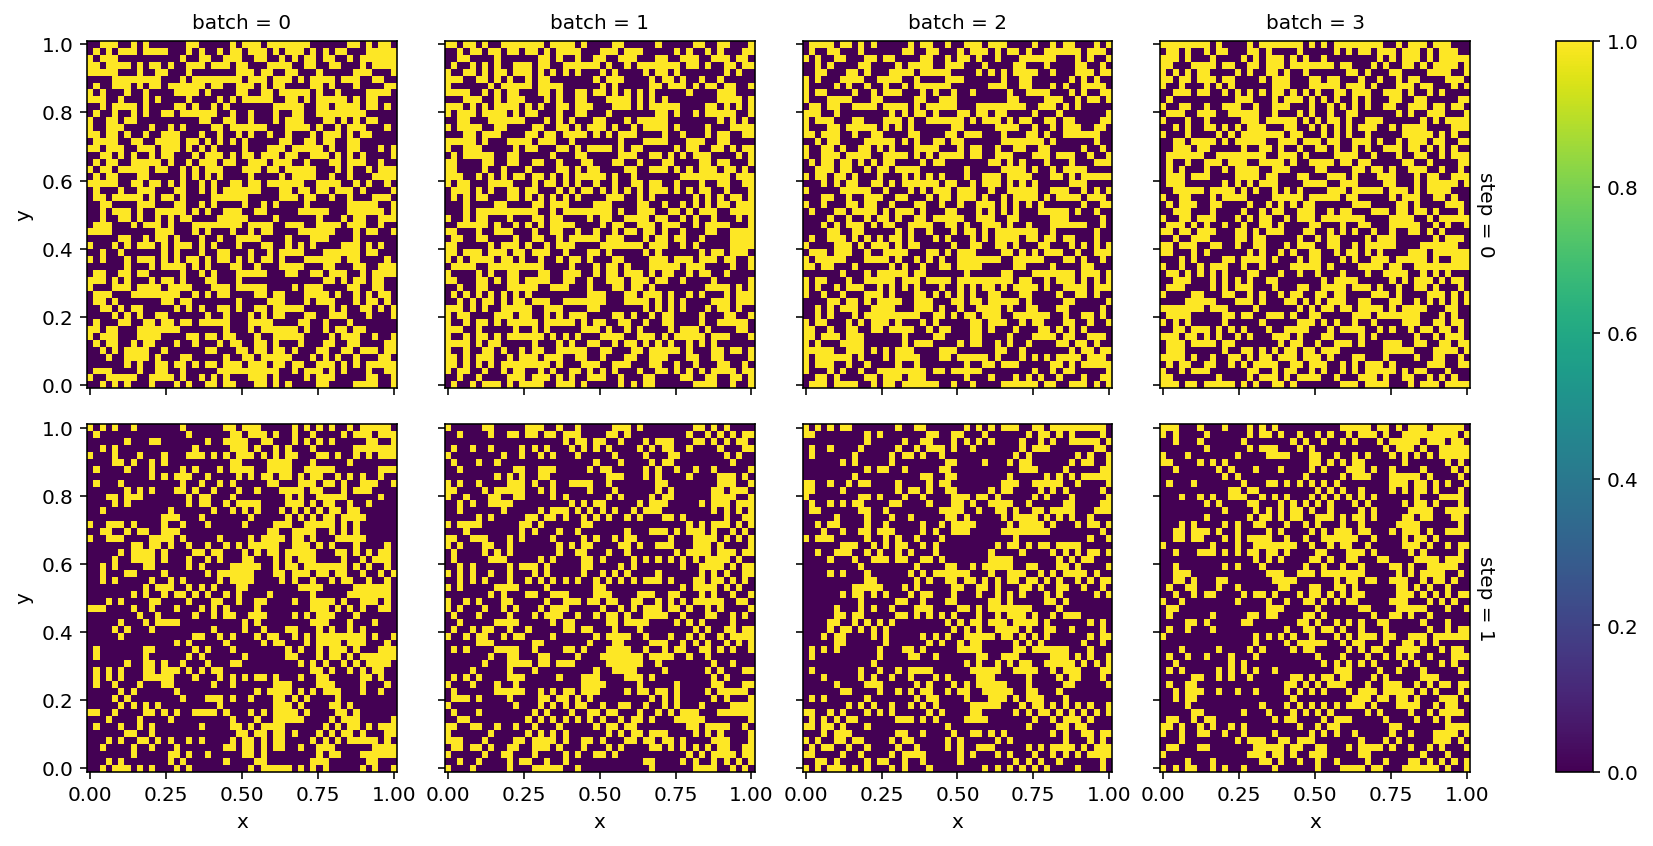

In [ ]:
ds = xarray.concat(
    [
        init_observations['game']['u'].to_xarray(),
        post_advance_observations['game']['u'].to_xarray(),
    ],
    'step'
)
ds.plot(x='x', y='y', row='step', col='batch')

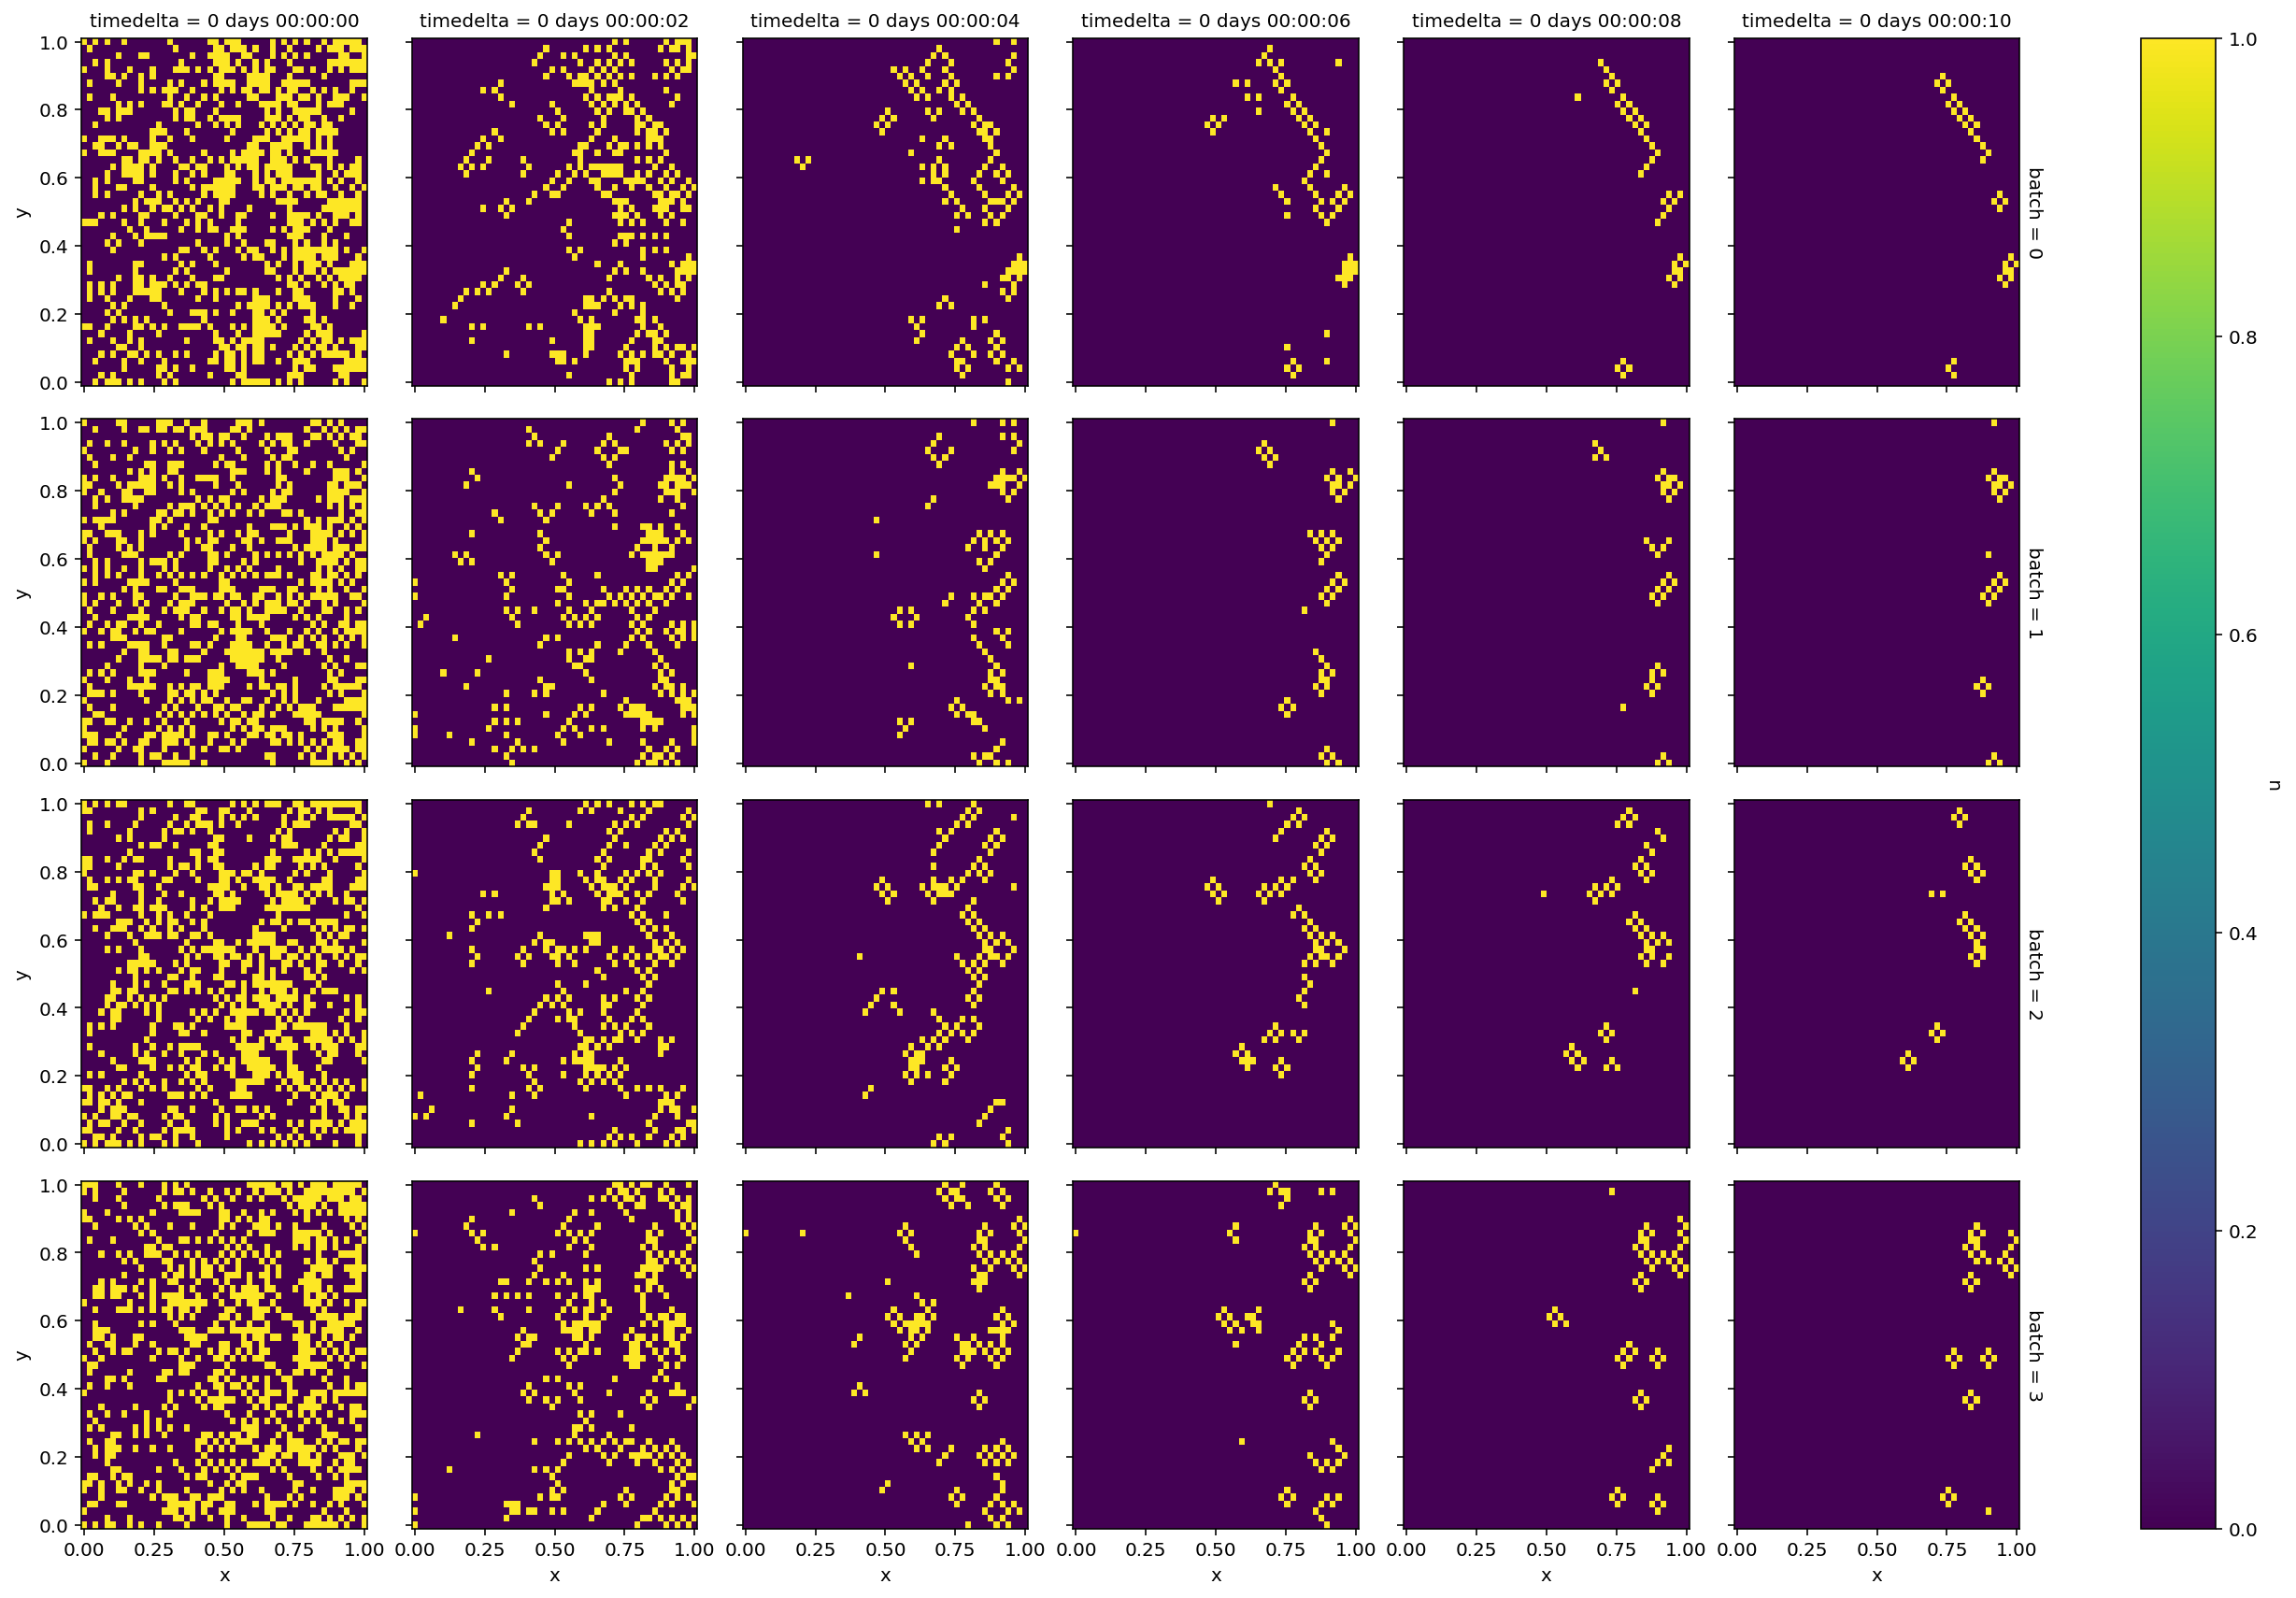

In [ ]:
observe_fn = lambda model: model.observe(observe_query | diagnostic_query)
unroll_fn = functools.partial(unroll_model, observe_fn=observe_fn)
observations = vectorized_life.run_vectorized(unroll_fn, b, 6, life.timestep * 2)
xarray_utils.fields_to_xarray(observations['game']).u.plot(x='x', y='y', col='timedelta', row='batch')

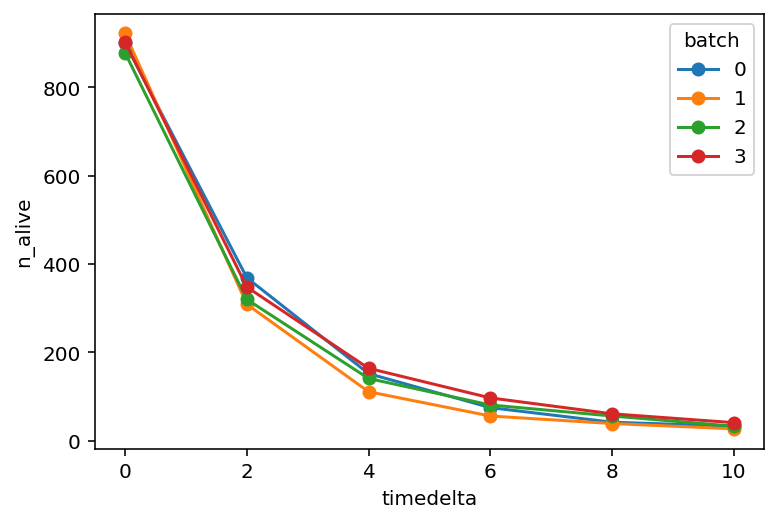

In [ ]:
xarray_utils.fields_to_xarray(observations['diagnostic']).n_alive.plot(x='timedelta', hue='batch', marker='o')

### Example 2: Batched Rollout (different dynamic data)

In [ ]:
life = build_new_model()
life.initialize_random_processes(rngs)

# Include dynamic input to vectorization specs.
vectorized_life = life.to_vectorized(
    {typing.Prognostic: b, typing.Diagnostic: b, typing.DynamicInput: b}
)

# update_dynamic_inputs now expects batched inputs.
vectorized_life.update_dynamic_inputs(batched_dynamic_inputs)
vectorized_life.assimilate(batched_inputs)
init_observations = vectorized_life.observe(observe_query)

vectorized_life.advance()
vectorized_life.advance()
vectorized_life.advance()

post_advance_observations = vectorized_life.observe(observe_query)

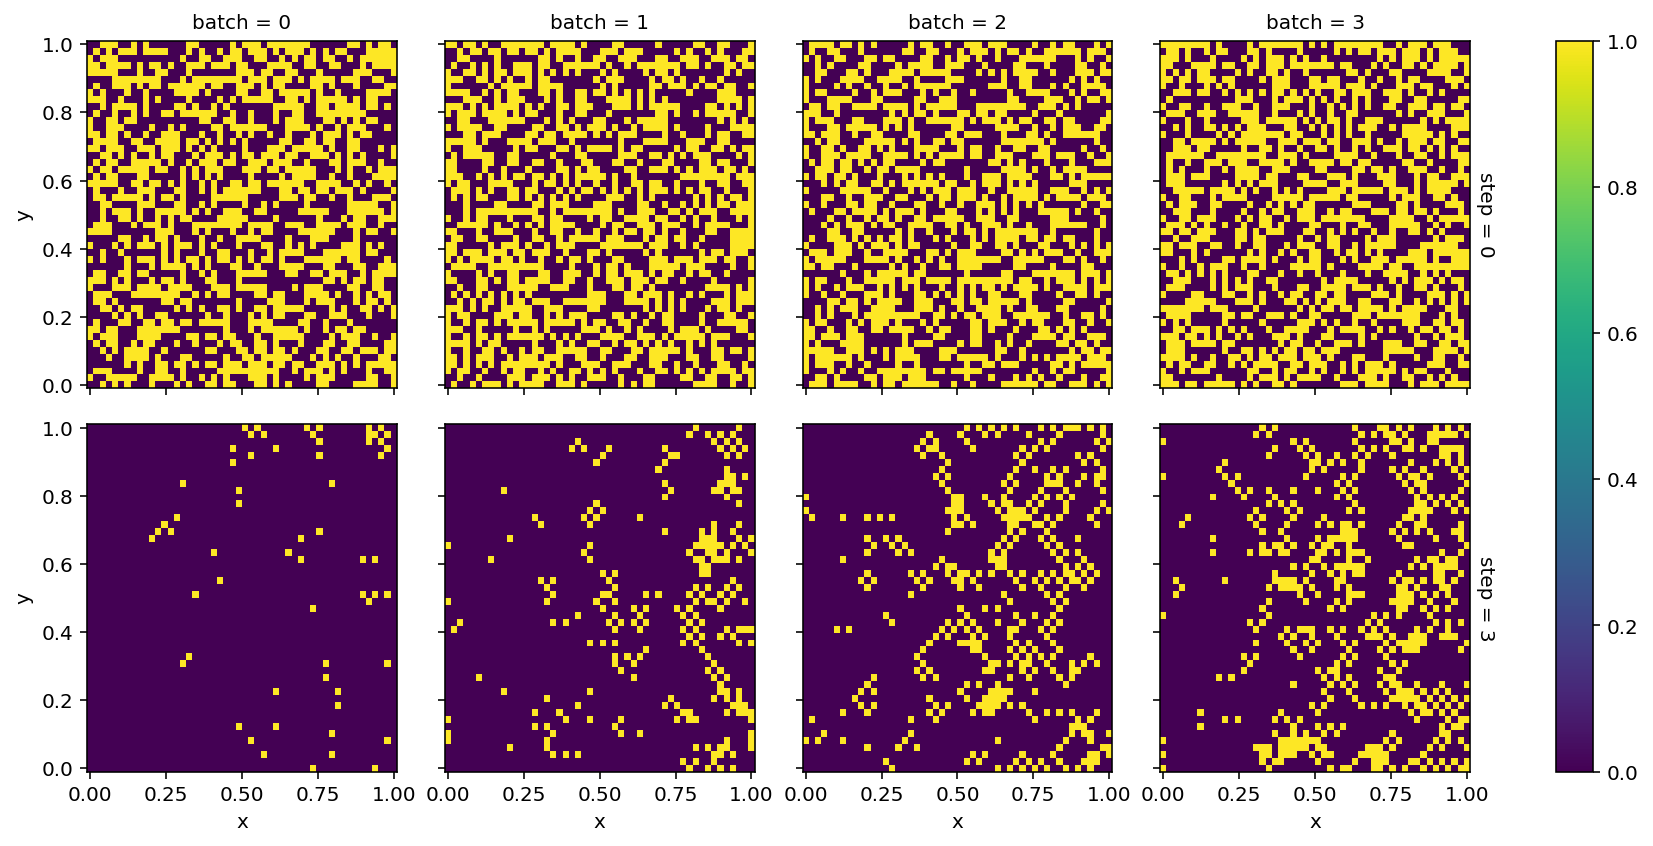

In [ ]:
ds = xarray.concat(
    [
        init_observations['game']['u'].to_xarray(),
        post_advance_observations['game']['u'].to_xarray(),
    ],
    'step'
)
ds.coords['step'] = np.arange(2) * 3
ds.plot(x='x', y='y', row='step', col='batch')

In the rollout above we can clearly see how different dynamic inputs affected rollouts across the batch dimension.

Each batch in this example experienced the same randomness. We accomplished this by carefully selecting the order of execution:
1. Initialized randomness on a fresh model
2. Replicated variables for prognostics, diagnostics and dynamic inputs
3. Updated dynamic inputs with batched data
4. Assimilated batched data
5. Ran advance vectorized over `b` axis (resulting in reuse of randomness)

### Example 3: Ensemble Rollout

In [ ]:
life = build_new_model()
life.update_dynamic_inputs(dynamic_inputs)
life.assimilate(inputs)
vectorized_life = life.to_vectorized(
    {typing.Prognostic: e, typing.Diagnostic: e, typing.Randomness: e}
)

# requires batched rngs to initialized vectorized random state.
vectorized_life.initialize_random_processes(e_rngs)
init_observations = vectorized_life.observe(observe_query)

for _ in range(4):
  vectorized_life.advance()
post_advance_observations = vectorized_life.observe(observe_query)

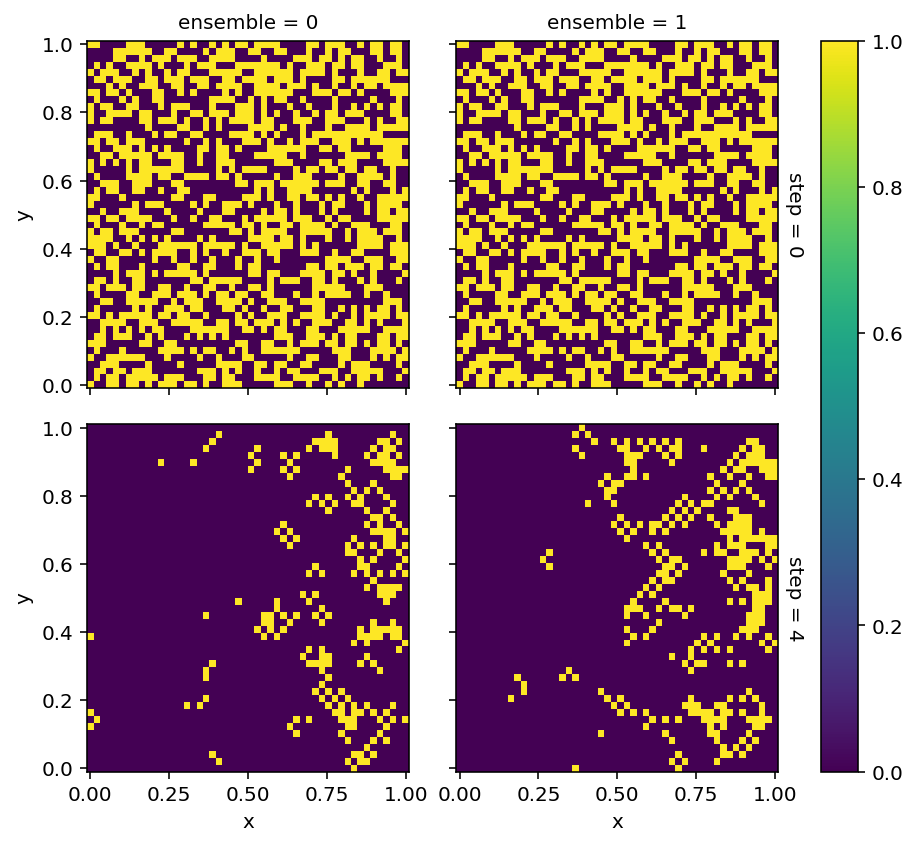

In [ ]:
ds = xarray.concat(
    [
        init_observations['game']['u'].to_xarray(),
        post_advance_observations['game']['u'].to_xarray(),
    ],
    'step'
)
ds.coords['step'] = np.arange(2) * 4
ds.plot(x='x', y='y', row='step', col='ensemble')

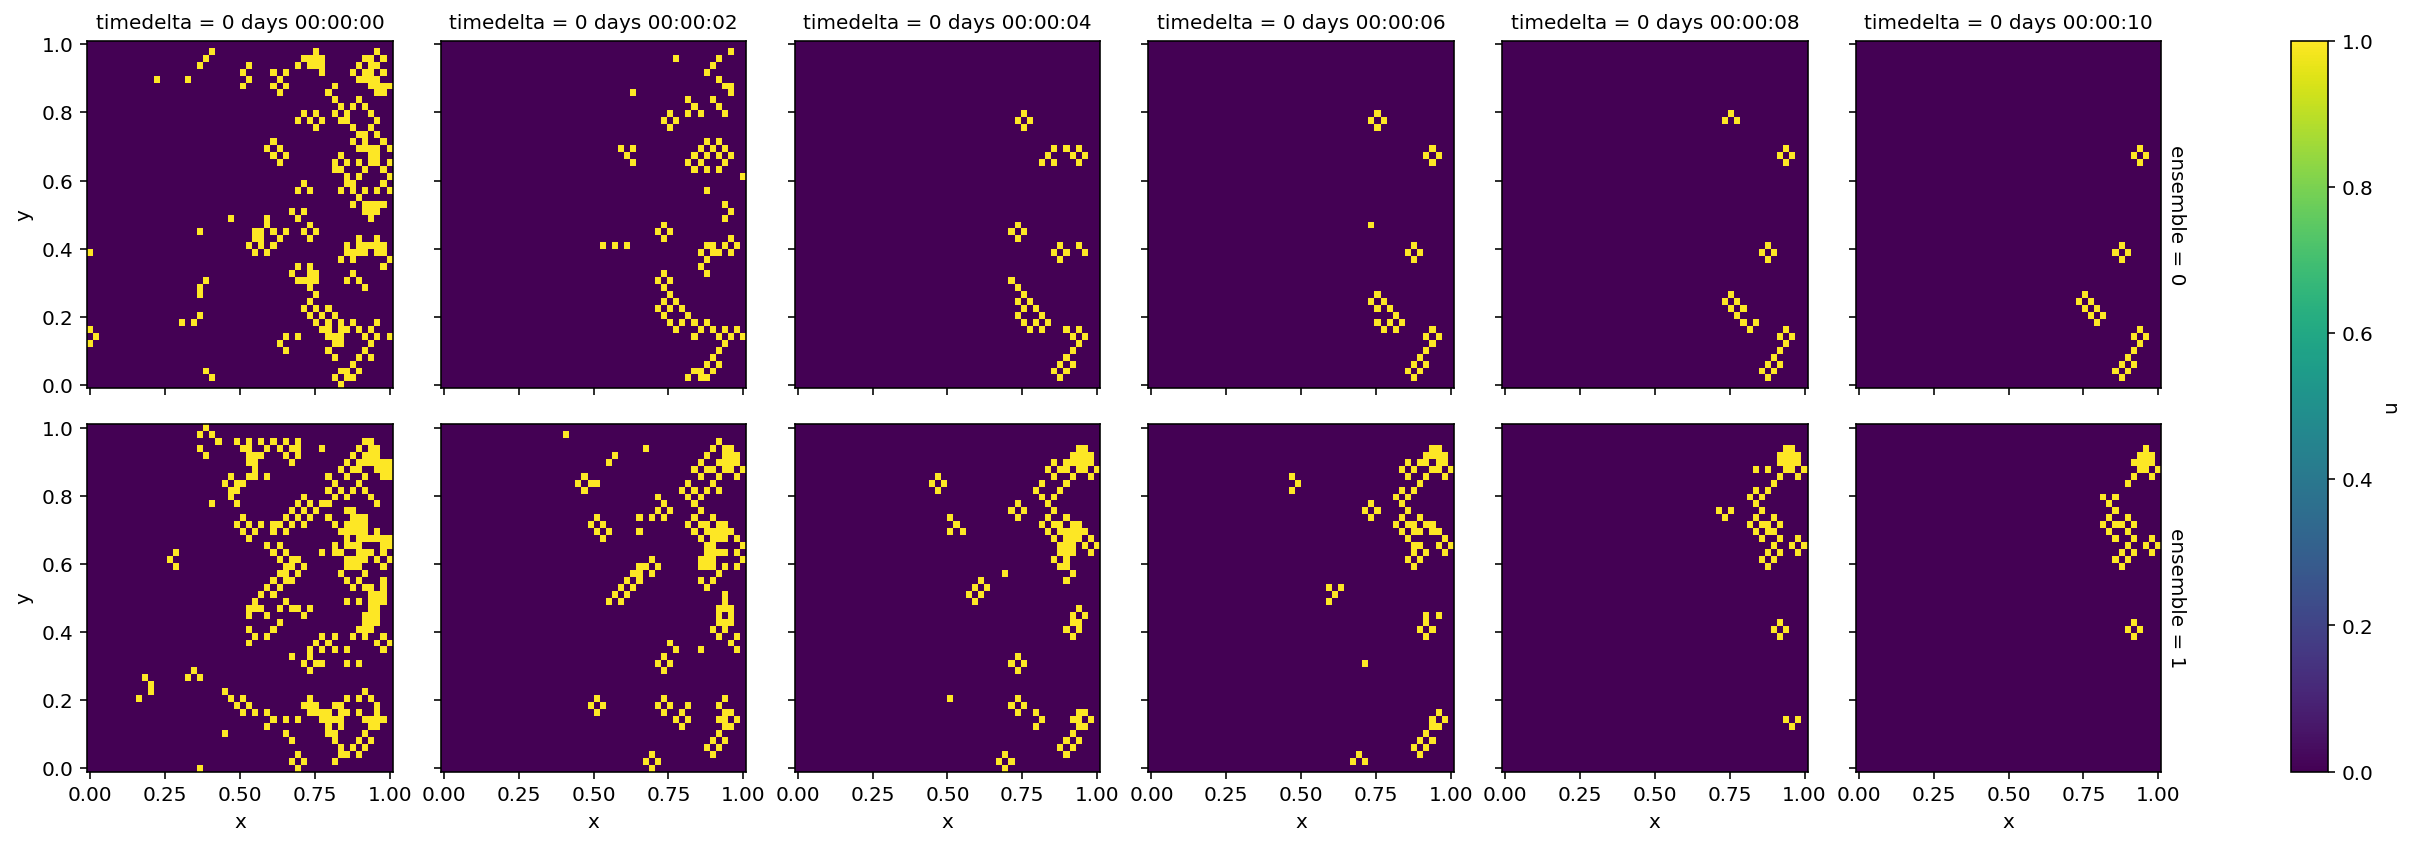

In [ ]:
observe_fn = lambda model: model.observe(observe_query | diagnostic_query)
unroll_fn = functools.partial(unroll_model, observe_fn=observe_fn)
observations = vectorized_life.run_vectorized(unroll_fn, e, 6, life.timestep * 2)
xarray_utils.fields_to_xarray(observations['game']).u.plot(x='x', y='y', col='timedelta', row='ensemble')

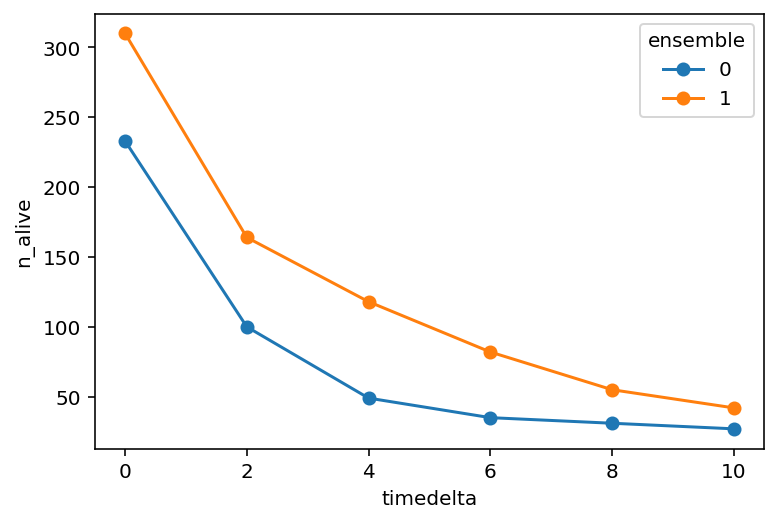

In [ ]:
xarray_utils.fields_to_xarray(observations['diagnostic']).n_alive.plot(x='timedelta', marker='o', hue='ensemble')

### Example 4: Ensemble of batches

Now let's produce an example that mimics model training with proper scoring rules: ensemble of batches;
This setup is trickier because it requires vectorizing the model twice. We first vectorize over the batch axis, then vectorize the already-vectorized model over the ensemble axis."

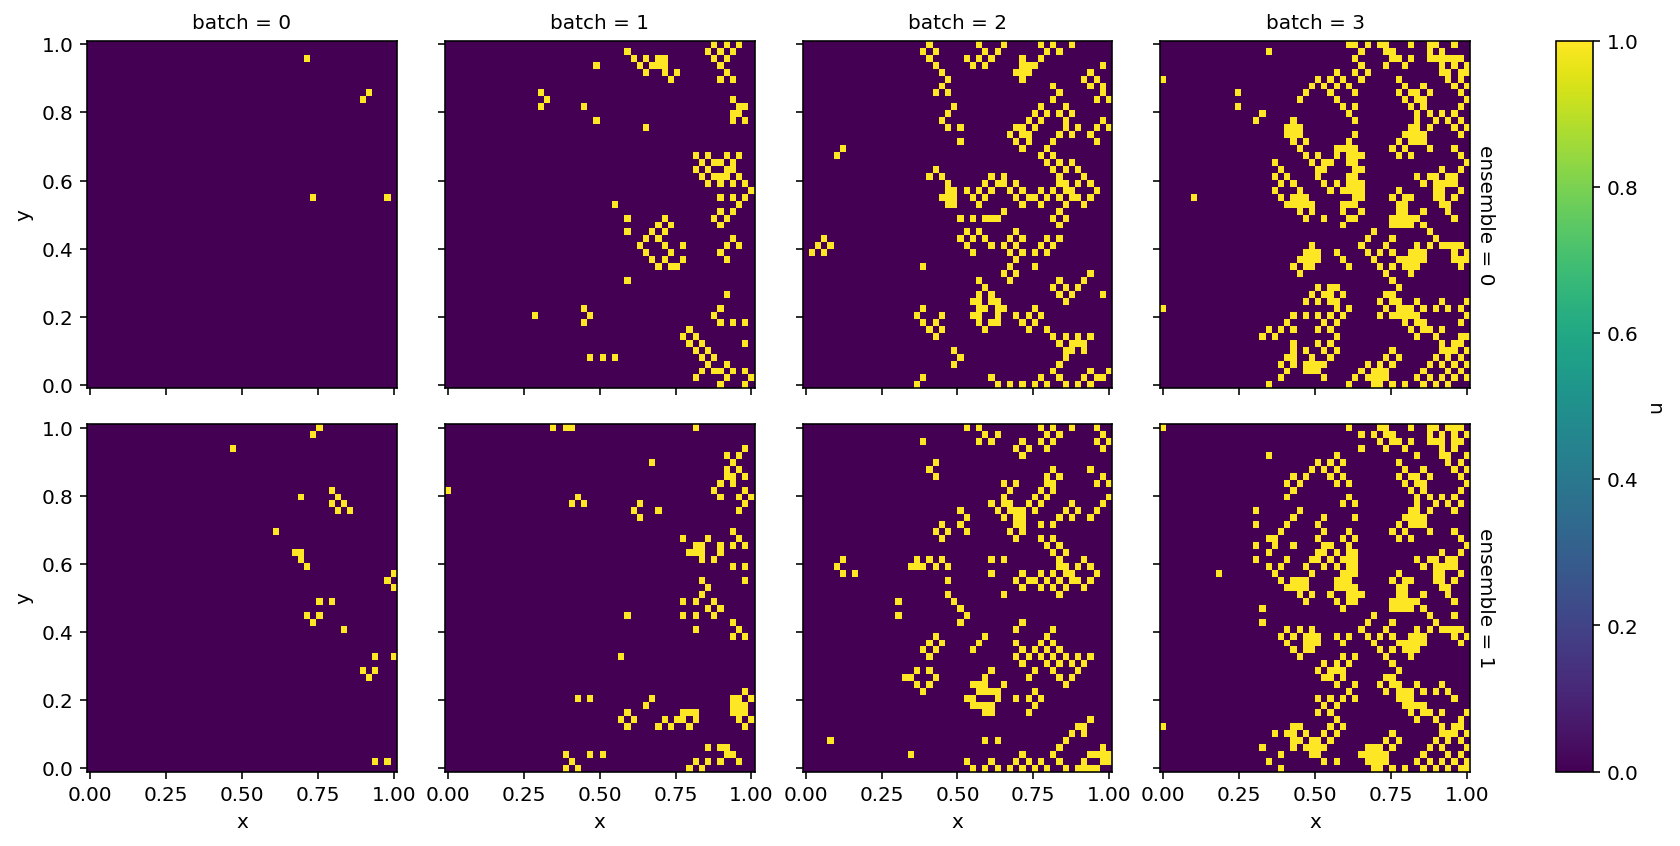

In [ ]:
life = build_new_model()
vectorized_life = life.to_vectorized({
    typing.Prognostic: b,
    typing.Diagnostic: b,
    typing.Randomness: b,
    typing.DynamicInput: b,
})
vectorized_life.update_dynamic_inputs(batched_dynamic_inputs)
vectorized_life.assimilate(batched_inputs)
vectorized_life = vectorized_life.to_vectorized({
    typing.Prognostic: e,
    typing.Diagnostic: e,
    typing.Randomness: e,
})
vectorized_life.initialize_random_processes(eb_rngs)
for _ in range(4):
  vectorized_life.advance()

post_advance_observations = vectorized_life.observe(observe_query)
xarray_utils.fields_to_xarray(post_advance_observations['game']).u.plot(
    x='x', y='y', row='ensemble', col='batch'
)

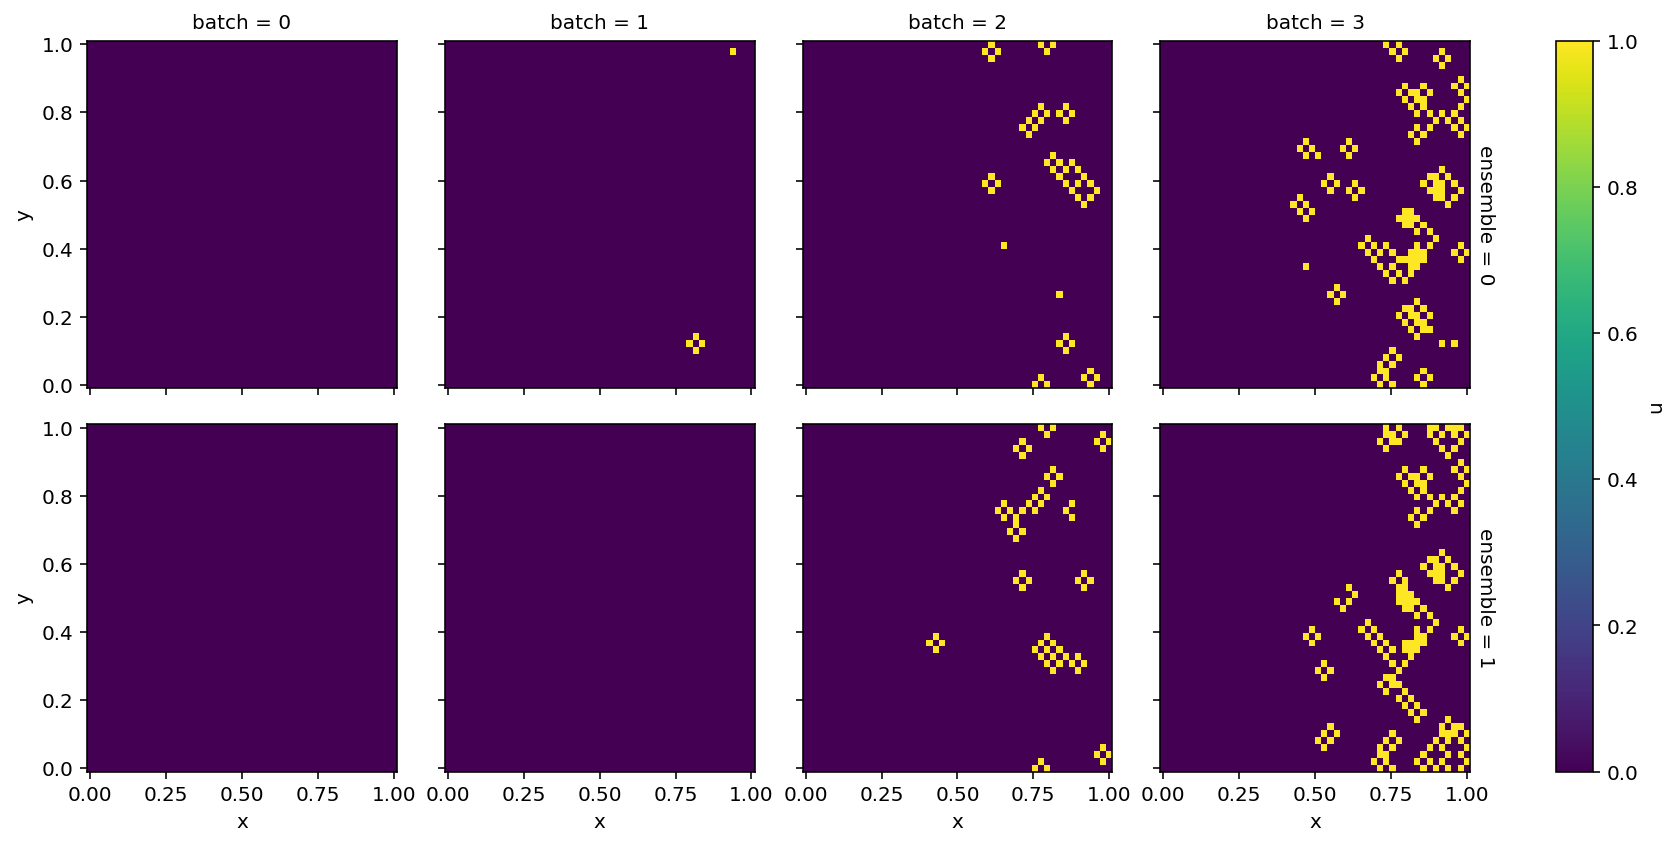

In [ ]:
observe_fn = lambda model: model.observe(observe_query | diagnostic_query)

def unroll_fn(model, outer_steps, timedelta):
  return unroll_model(model, outer_steps=outer_steps, timedelta=timedelta, observe_fn=observe_fn)

# note that in this doubly vectorized example we pass a cartesian product of
# coordinates to `run_vectorized`. This ensures that `unroll_fn` is wrapped in a
# nested `vmap` over corresponding slices of the model state.
observations = vectorized_life.run_vectorized(
    unroll_fn, cx.compose_coordinates(e, b), 6, life.timestep * 2
)
xarray_utils.fields_to_xarray(observations['game']).u.isel(timedelta=5).plot(x='x', y='y', col='batch', row='ensemble')

<Axes: xlabel='timedelta', ylabel='n_alive'>

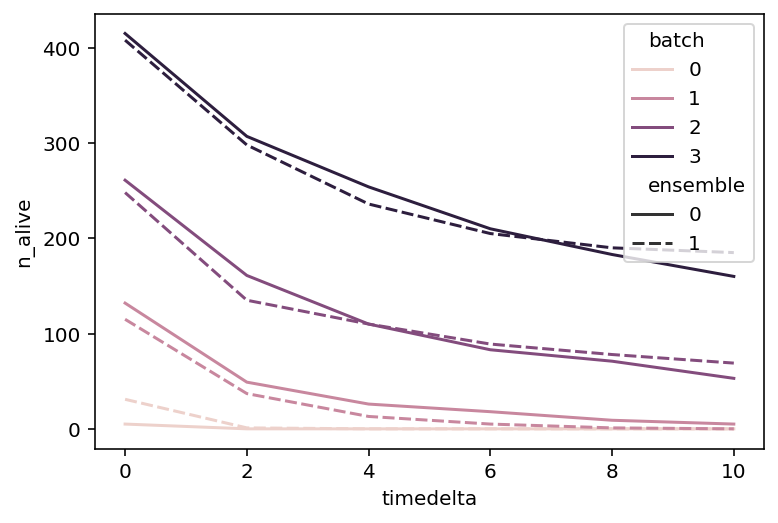

In [ ]:
sns.lineplot(
    data=xarray_utils.fields_to_xarray(observations['diagnostic']).n_alive.to_dataframe().reset_index(),
    x='timedelta',
    y='n_alive',
    hue='batch',
    style='ensemble'
)